In [14]:
# !pip install tensorflow==2.15.0
# !pip install tf_keras==2.15.0

In [15]:
# Use legacy Keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [16]:
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs

from src.tower import Tower
from src.embedding import Embedding
from src.recommender import RecommenderModel
from src.utils.utilities import (
    parquet_to_Dataset,
    train_test_split,
    plot_history,
)

RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)

In [17]:
# Load ratings dataset
ratings_dataset = parquet_to_Dataset(
    path = 'data/100k-ratings.parquet',
    exclude_columns = ['movie_genres']
)

# Load movies dataset
movies_dataset = parquet_to_Dataset(
    path = 'data/100k-movies.parquet',
    exclude_columns = ['movie_genres']
)

### Dataset Splitting

In [18]:
# Split ratings dataset into train and validation
ratings_trainset, ratings_validset = train_test_split(
    dataset = ratings_dataset,
    train_size = 0.8,
    random_state = RANDOM_STATE,
    buffer_size = 10_000
)

print(f"trainset_size:", ratings_trainset.__len__().numpy())
print(f"validset_size:", ratings_validset.__len__().numpy())

trainset_size: 80000
validset_size: 20000


In [19]:
# Create user embedding
user_embedding_model = Embedding(
    dataset = ratings_trainset.batch(1_000_000),
    str_features = ['user_id', 'user_zip_code', 'user_occupation_text'],
    int_features = ['user_gender', 'bucketized_user_age'],
    text_features = [],
    timestamp_features = ['timestamp'],
    embedding_dim = 32,
)

# Create movie embedding
movie_embedding_model = Embedding(
    dataset = ratings_trainset.batch(1_000),
    str_features = [],
    int_features = [],
    text_features = ['movie_title'],
    timestamp_features = [],
    embedding_dim = 32,
)

In [20]:
cross_layer = tfrs.layers.dcn.Cross(
    projection_dim = 32,
    kernel_initializer = "glorot_uniform"
)

candidate_tower = Tower(
    embedding_model = movie_embedding_model,
    cross_layer = cross_layer,
    dense_layers = [32]
)

query_tower = Tower(
    embedding_model = user_embedding_model,
    cross_layer = cross_layer,
    dense_layers = [32]
)

factorized_top_k_metrics = tfrs.metrics.FactorizedTopK(
    candidates = movies_dataset.batch(128).map(candidate_tower)
)

In [21]:
# Ranking
ranking_task = tfrs.tasks.Ranking(
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(),
    ]
)

# Retrieval
retrieval_task = tfrs.tasks.Retrieval(
    metrics = [
        factorized_top_k_metrics
    ]
)

model = RecommenderModel(
    query_tower = query_tower,
    candidate_tower = candidate_tower,
    ranking_task = ranking_task,
    retrieval_task = retrieval_task,
    retrieval_weight = 0.2,
    ranking_weight = 0.8,
)

optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)
model.compile(optimizer = optimizer)

In [22]:
cached_ratings_trainset = ratings_trainset.shuffle(100_000).batch(1024).cache()
cached_ratings_validset = ratings_validset.batch(1024).cache()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'total_loss',
    patience = 10,
)

history = model.fit(
    cached_ratings_trainset,
    validation_data = cached_ratings_validset,
    validation_freq = 1,
    epochs = 10,
    callbacks = [
        early_stopping_callback
    ]
)

Epoch 1/10
79/79 [==============================] - 14s 80ms/step - root_mean_squared_error: 0.0000e+00 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 1355.4092 - regularization_loss: 0.0000e+00 - total_loss: 1355.4092 - val_root_mean_squared_error: 1.1243 - val_factorized_top_k/top_1_categorical_accuracy: 0.0014 - val_factorized_top_k/top_5_categorical_accuracy: 0.0096 - val_factorized_top_k/top_10_categorical_accuracy: 0.0195 - val_factorized_top_k/top_50_categorical_accuracy: 0.1033 - val_factorized_top_k/top_100_categorical_accuracy: 0.1998 - val_loss: 645.6268 - val_regularization_loss: 0.0000e+00 - val_total_loss: 645.6268
Epoch 2/10
79/79 [==============================] - 3s 41ms/step - root_mean_squared_error: 0.0000e+00 - fac

In [23]:
model.evaluate(cached_ratings_validset, return_dict=True)

20/20 [==============================] - 2s 101ms/step - root_mean_squared_error: 0.9938 - factorized_top_k/top_1_categorical_accuracy: 4.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0071 - factorized_top_k/top_10_categorical_accuracy: 0.0181 - factorized_top_k/top_50_categorical_accuracy: 0.1257 - factorized_top_k/top_100_categorical_accuracy: 0.2604 - loss: 1258.9953 - regularization_loss: 0.0000e+00 - total_loss: 1258.9953


{'root_mean_squared_error': 0.9937780499458313,
 'factorized_top_k/top_1_categorical_accuracy': 0.00044999999227002263,
 'factorized_top_k/top_5_categorical_accuracy': 0.0071000000461936,
 'factorized_top_k/top_10_categorical_accuracy': 0.01810000091791153,
 'factorized_top_k/top_50_categorical_accuracy': 0.1256999969482422,
 'factorized_top_k/top_100_categorical_accuracy': 0.2603999972343445,
 'loss': 625.3150634765625,
 'regularization_loss': 0,
 'total_loss': 625.3150634765625}

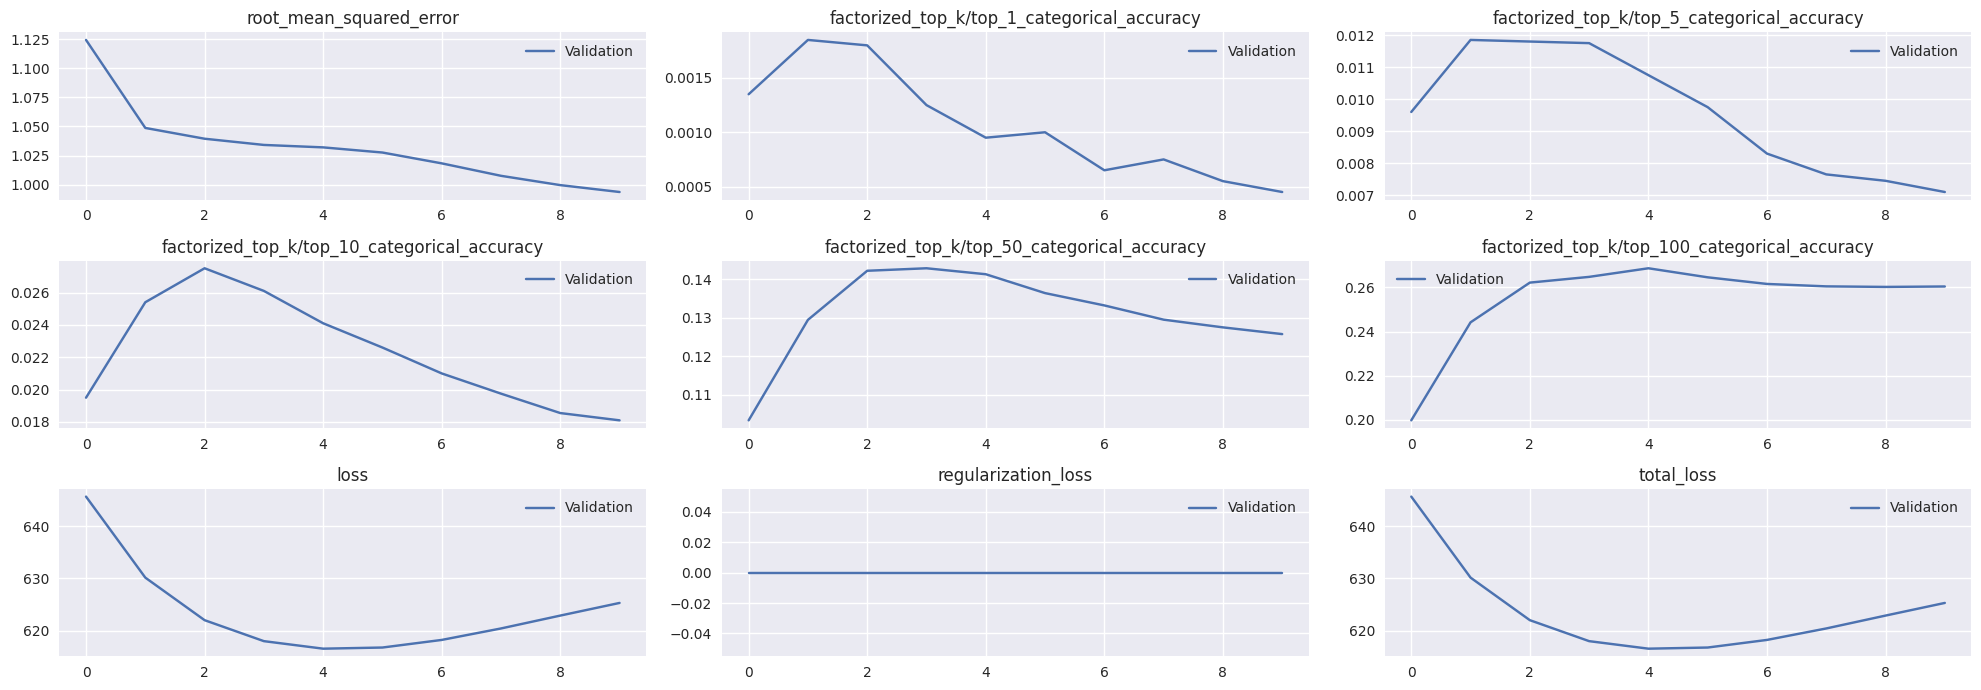

In [24]:
plot_history(history = history, plot_training=False)

In [25]:
# scann_layer = tfrs.layers.factorized_top_k.ScaNN(
#     model.query_tower,
#     k = 10,
# )

# scann_layer.index_from_dataset(
#   tf.data.Dataset.zip(
#       (
#           movies_dataset.map(lambda movie: movie['movie_id']).batch(100),
#           movies_dataset.batch(100).map(model.candidate_tower)
#       )
#   )
# )

In [26]:
# index = 0
# data = ratings_dataset.take(1).as_numpy_iterator().next()
# data = {k: tf.convert_to_tensor([v]) for k, v in data.items()}

# afinity_scores, movie_ids = scann_layer(data)

# for movie_id in movie_ids[0]:

#     pred = model(data)
#     _, _, rating = pred

#     print(f"Movie {movie_id}: {rating[0][0]}")